In [1]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from scipy import stats
from scipy.stats import norm, skew

#### Read data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.columns = [c.lower() for c in train.columns]
test.columns = [c.lower() for c in test.columns]
sub_index = test['id']
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
train_objs_num = len(train)
y = train['saleprice']
dataset = pd.concat(objs=[train.drop(columns=['saleprice']), test], axis=0)
df = dataset.copy()
train_objs_num = len(train)

train= dataset[:train_objs_num]
train['saleprice'] = y
test = dataset[train_objs_num:]

In [3]:
print(train.shape,test.shape,dataset.shape)
dataset.head()

(1460, 80) (1459, 79) (2919, 79)


,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
mssubclass       2919 non-null int64
mszoning         2915 non-null object
lotfrontage      2433 non-null float64
lotarea          2919 non-null int64
street           2919 non-null object
alley            198 non-null object
lotshape         2919 non-null object
landcontour      2919 non-null object
utilities        2917 non-null object
lotconfig        2919 non-null object
landslope        2919 non-null object
neighborhood     2919 non-null object
condition1       2919 non-null object
condition2       2919 non-null object
bldgtype         2919 non-null object
housestyle       2919 non-null object
overallqual      2919 non-null int64
overallcond      2919 non-null int64
yearbuilt        2919 non-null int64
yearremodadd     2919 non-null int64
roofstyle        2919 non-null object
roofmatl         2919 non-null object
exterior1st      2918 non-null object
exterior2nd      2918 non

#### EDA

In [5]:
# Check if saleprice > = 0
train.describe()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


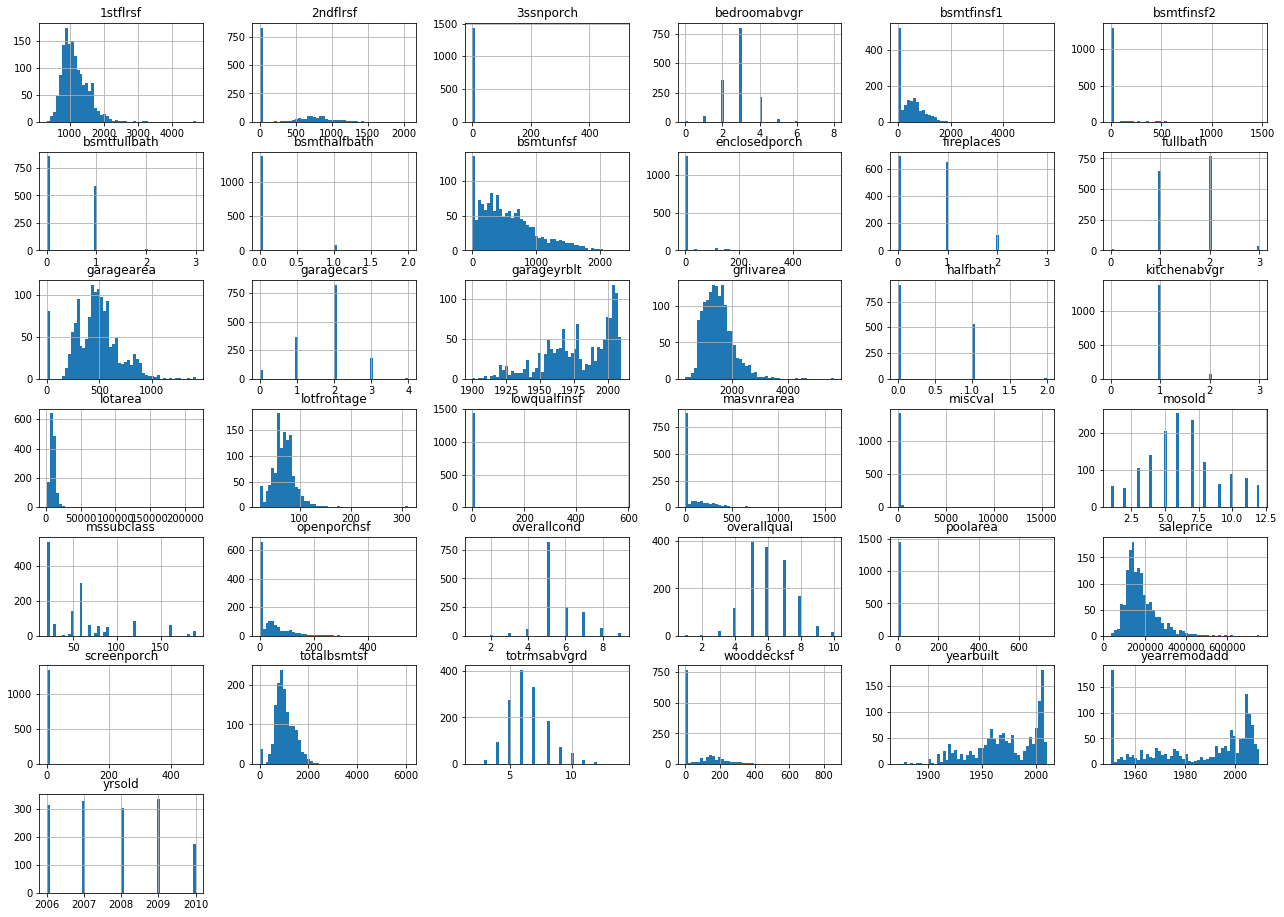

In [6]:
train.hist(bins=50, figsize=(22,16))
plt.show()

Note  that the histogram function only displays sets for those columns with numerical values. 

### Target Variable


 mu = 180921.20 and sigma = 79415.29



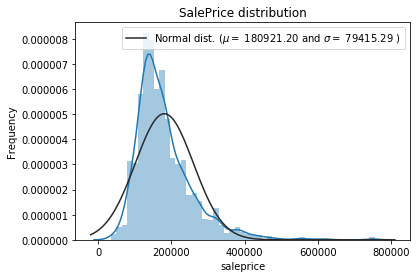

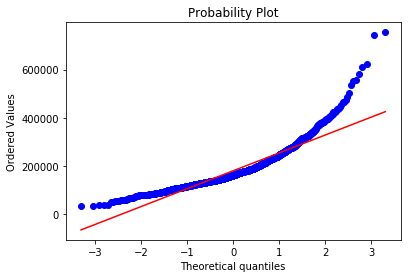

In [7]:
## Target Variable
sns.distplot(train['saleprice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['saleprice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['saleprice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



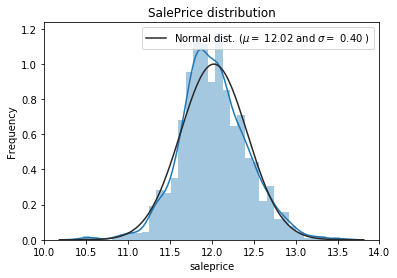

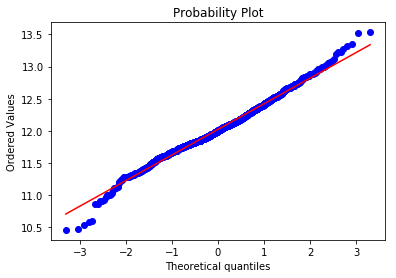

In [8]:
# The target variable is right skewed. As (linear) models love normally distributed data , we need
# to transform this variable and make it more normally distributed.

#Log-transformation of the target variable

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_log = train.copy()
train_log["saleprice"] = np.log1p(train["saleprice"])
y = train_log["saleprice"]

#Check the new distribution 
sns.distplot(train_log['saleprice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_log['saleprice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_log['saleprice'], plot=plt)
plt.show()

### Missing Values

,Total,Percent
poolqc,2909,0.996574
miscfeature,2814,0.964029
alley,2721,0.932169
fence,2348,0.804385
fireplacequ,1420,0.486468
lotfrontage,486,0.166495
garagecond,159,0.054471
garagequal,159,0.054471
garageyrblt,159,0.054471
garagefinish,159,0.054471


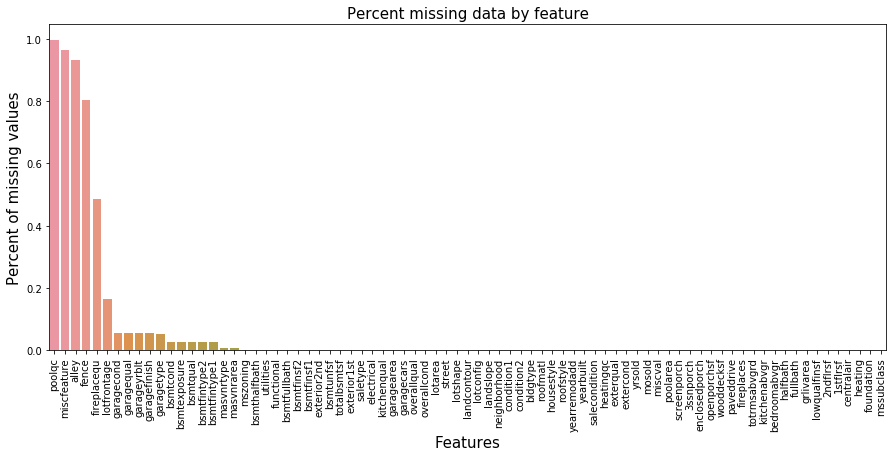

In [9]:
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.set_context("paper")
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data[missing_data.Total>0]

### Correlation matrix

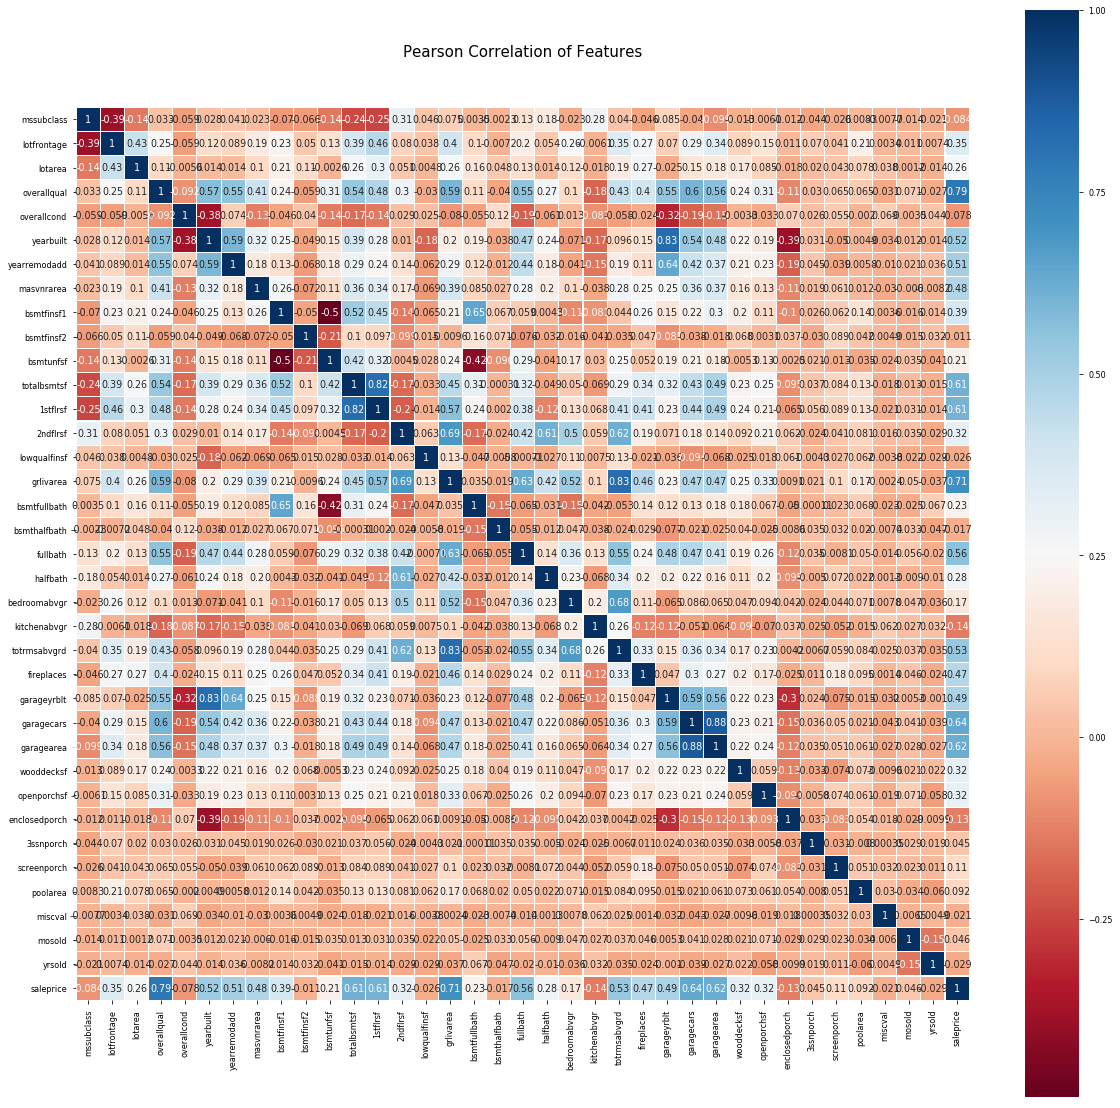

In [10]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.select_dtypes(exclude='object').corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Tha above plot is hard to read. Thus we will filter so that it illustrates those vaiables that are highly coorelated with the target varibale 'saleprice'.

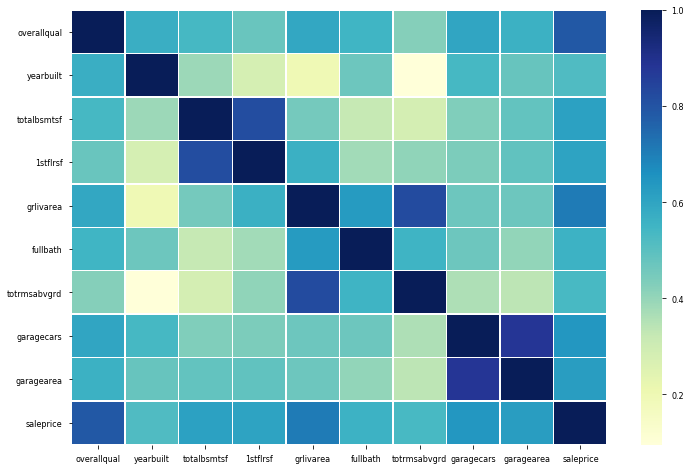

In [11]:
mask = abs(train.corr()['saleprice']) >= 0.52
plt.figure(figsize=(12,8))
l = [c for c in mask[mask==True].index]
sns.heatmap(train[l].corr(),linewidths=.5,cmap="YlGnBu")

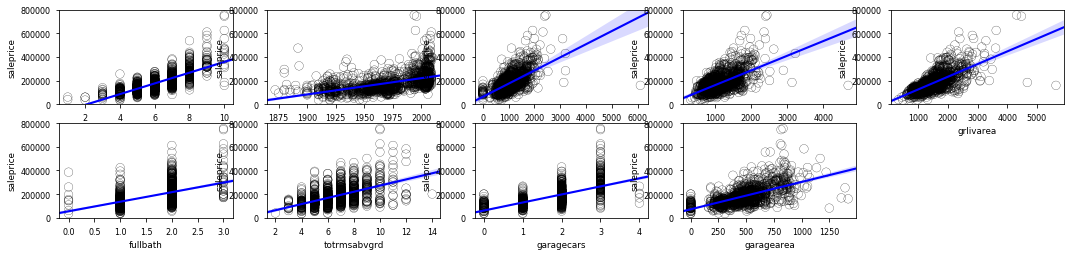

In [12]:
mask = abs(train.corr()['saleprice']) >= 0.52
l = [c for c in mask[mask==True].index]
plt.figure(figsize=(18,8))
for i in range(len(l)-1):
    ii = '45'+str(i+1)
    plt.subplot(ii)
    plt.scatter(train[l[i]], train['saleprice'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = l[i], y = 'saleprice', data = train,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,800000])

**Variables most correlated with 'SalePrice'**

<br>'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
<br>'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables as the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
<br>'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF' just to say that our first guess was right
<br>'TotRmsAbvGrd' and 'GrLivArea', twin brothers again.

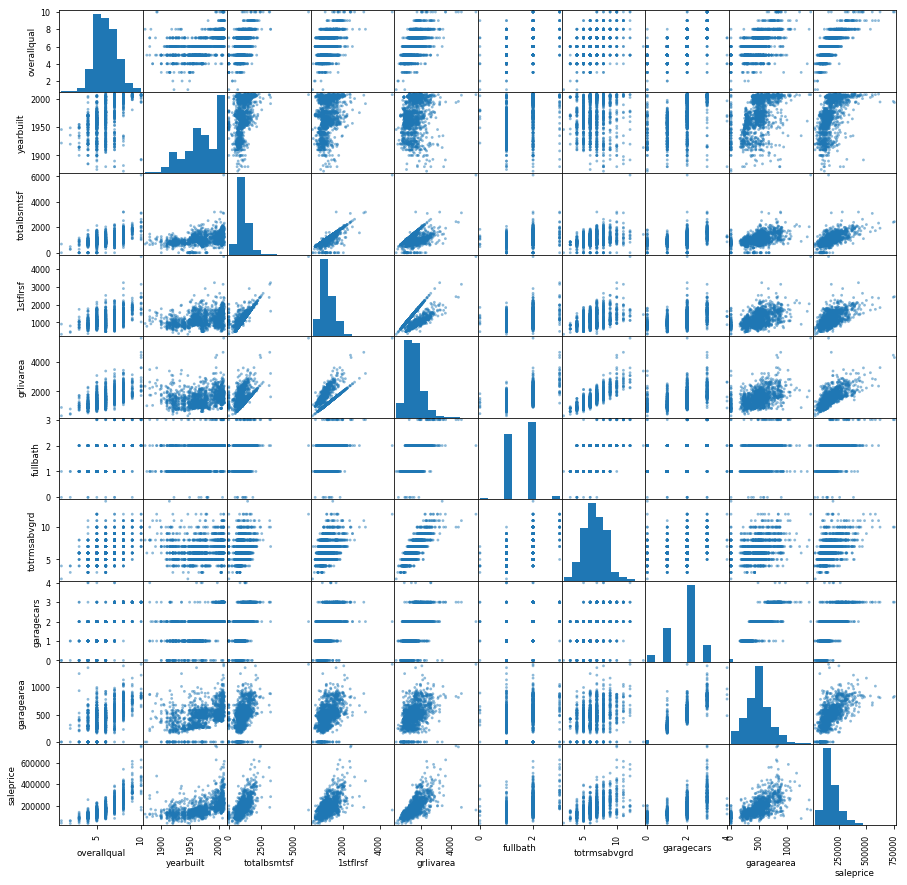

In [13]:
scatter_matrix = pd.scatter_matrix(
    train[l],
    figsize  = [15, 15],
    marker   = "."
)

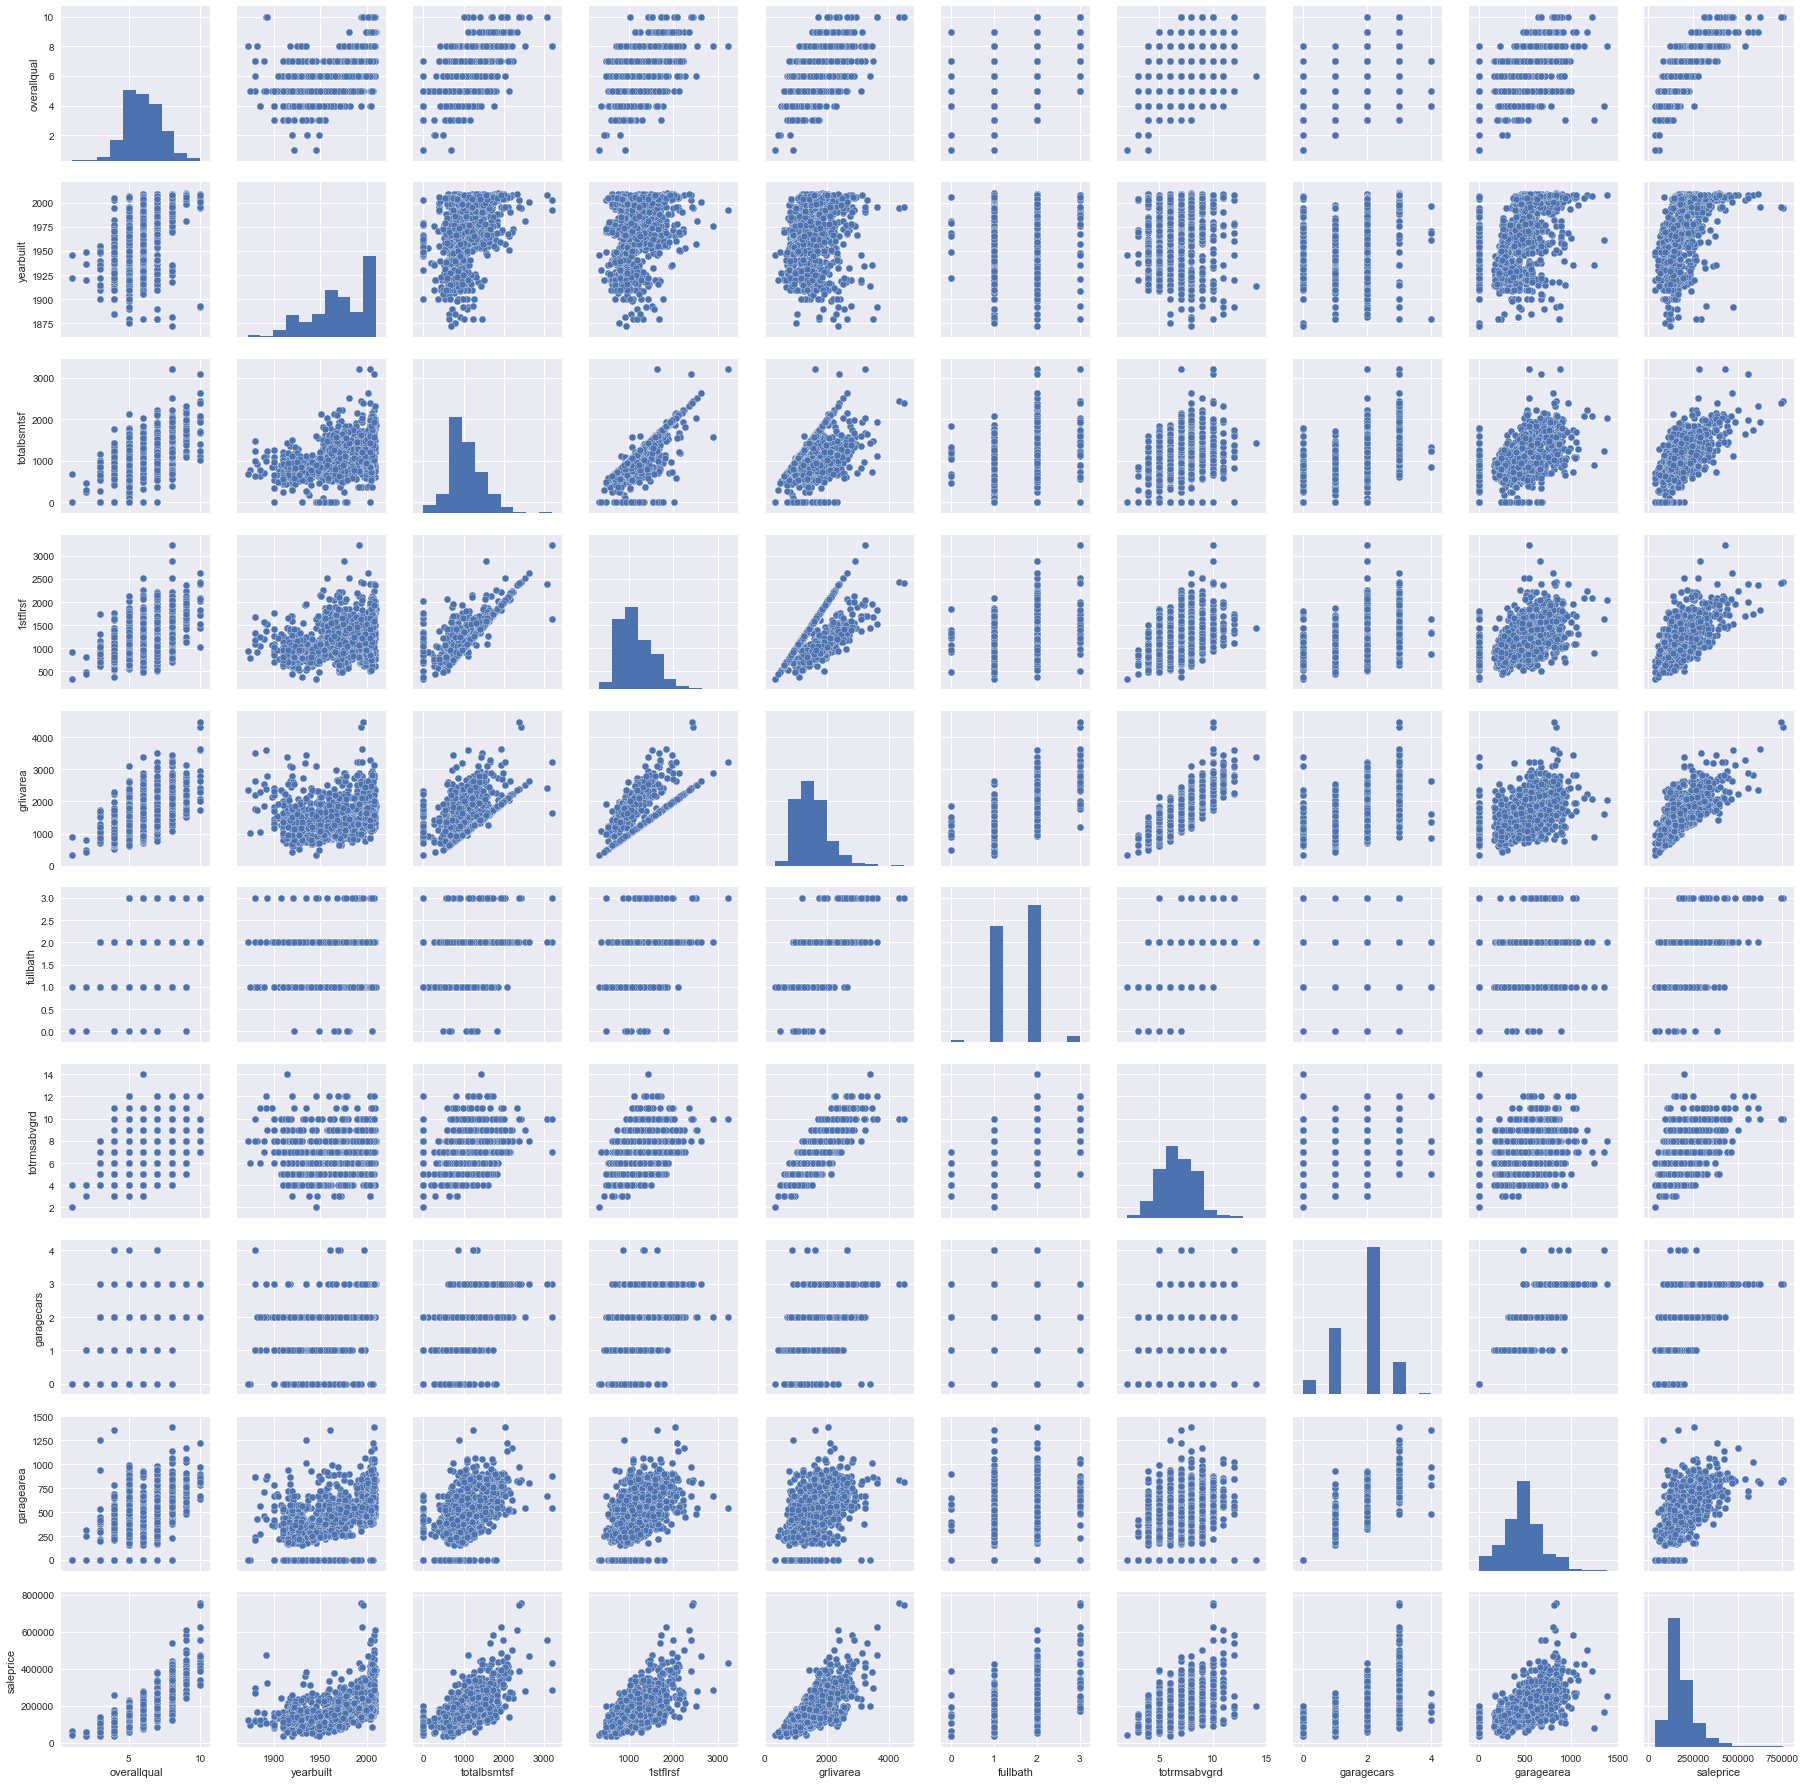

In [24]:
mask = abs(train.corr()['saleprice']) >= 0.52
l = [c for c in mask[mask==True].index]
sns.set()
sns.pairplot(train[l], size = 2.5)
plt.show()

One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area (unless you're trying to buy a bunker).

The plot concerning 'SalePrice' and 'YearBuilt' can also make us think. In the bottom of the 'dots cloud', we see what almost appears to be a shy exponential function (be creative). We can also see this same tendency in the upper limit of the 'dots cloud' (be even more creative). Also, notice how the set of dots regarding the last years tend to stay above this limit (I just wanted to say that prices are increasing faster now).

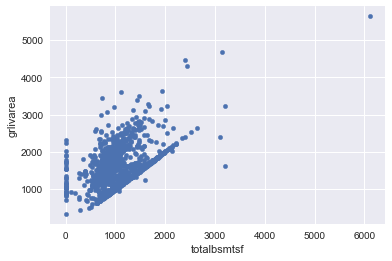

In [15]:
train.plot.scatter(x='totalbsmtsf', y='grlivarea')

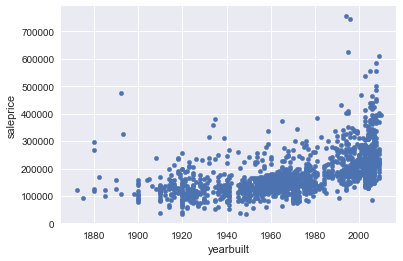

In [16]:
train.plot.scatter(x='yearbuilt', y='saleprice')

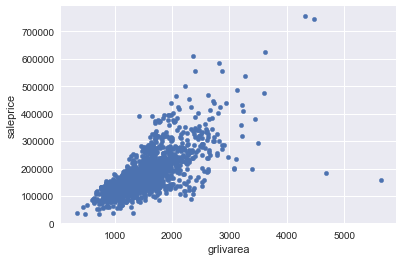

In [17]:
train.plot.scatter(x='grlivarea', y='saleprice')

The two values with bigger 'GrLivArea' seem strange and they are not following the crowd.Maybe they refer to agricultural area and that could explain the low price. However, these two points are not representative of the typical case. Therefore, we'll define them as outliers and delete them.
The two observations in the top of the plot look like two special cases, however they seem to be following the trend. For that reason, we will keep them.

In [18]:
#deleting points
p = train.sort_values(by = 'grlivarea', ascending = False)[:2].index
train = train.drop([p[0],p[1]])

#### Relationships of target variable with categorical features

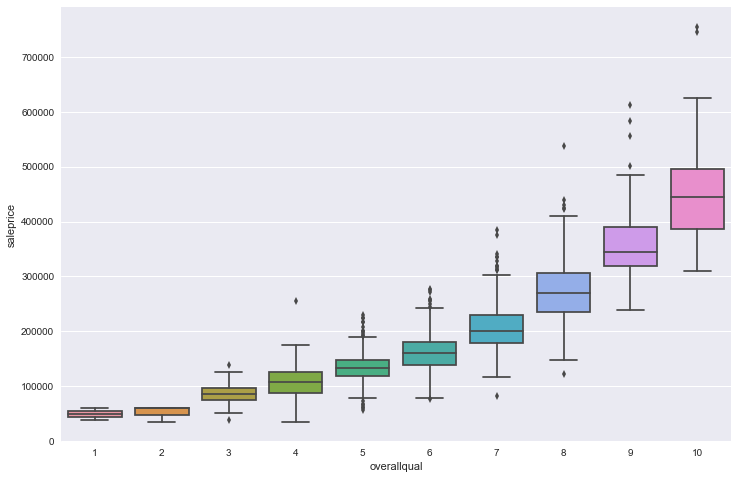

In [19]:
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=train['overallqual'], y=train['saleprice'])

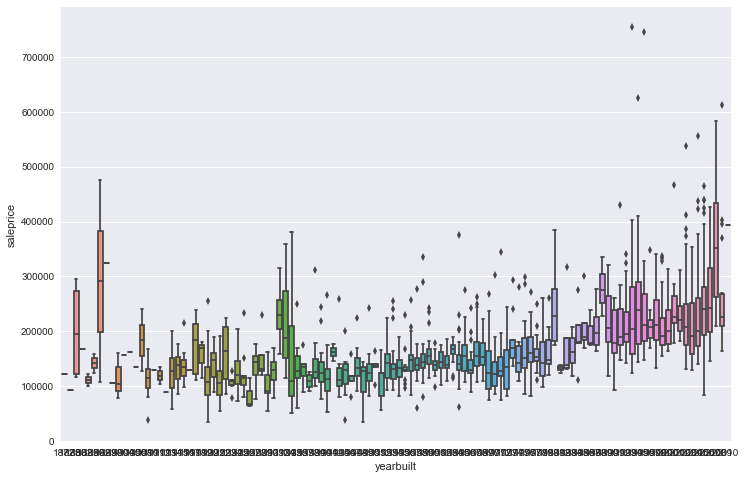

In [20]:
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=train['yearbuilt'], y=train['saleprice'])

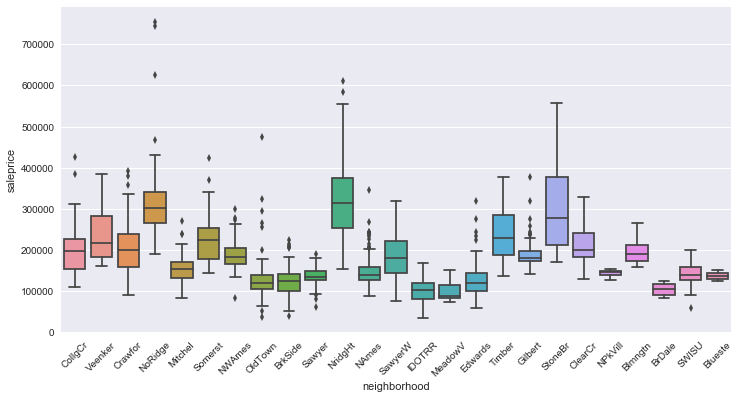

In [21]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'neighborhood', y = 'saleprice',  data = train)
xt = plt.xticks(rotation=45)

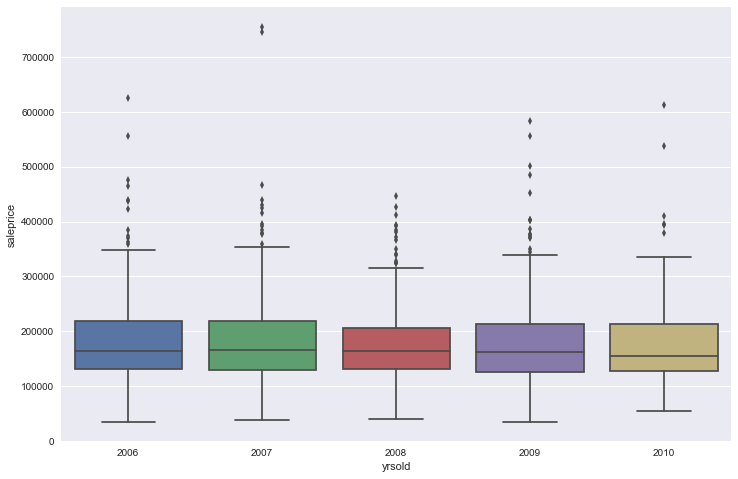

In [22]:
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=train['yrsold'], y=train['saleprice'])

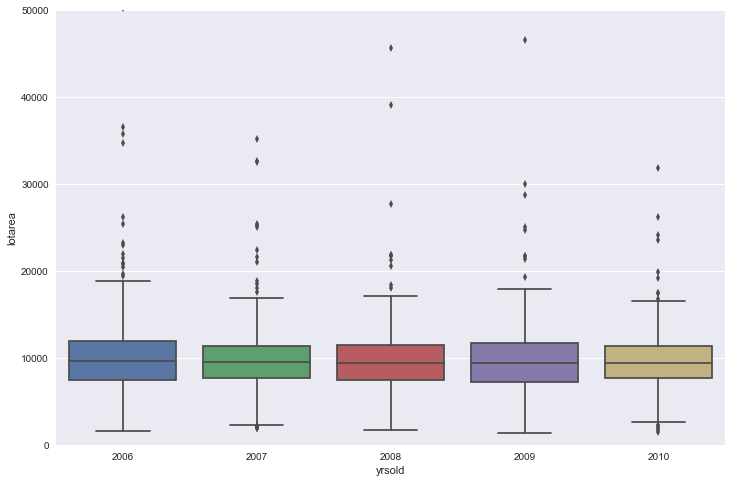

In [23]:
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=train['yrsold'], y=train['lotarea'])
fig.axis(ymin=0, ymax=50000);

**In summary:**
<br>'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
<br>'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.
We just analysed four variables, but there are many other that we should analyse. The trick here seems to be the choice of the right features (feature selection) and not the definition of complex relationships between them (feature engineering).